In [1]:
import torch
print(torch.cuda.get_device_name(0))
print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Tesla V100-PCIE-32GB
Total GPU memory: 31.74 GB
Allocated: 0.00 GB
Reserved: 0.00 GB


In [2]:
import os
print(os.environ.get('CUDA_LAUNCH_BLOCKING'))

None


In [3]:
!nvidia-smi

Mon May 26 19:01:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   34C    P0              27W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Run in Python shell
import torch
print(torch.cuda.is_available())  # Should return True

True


In [5]:
# Switch path to root of project if running from notebook subfolder
import os
import sys
import gc

%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import center_crop
from tokenizers import Tokenizer
import matplotlib.pyplot as plt

# Imports from the 4M library (based on retrieval_4M-21.ipynb)
from fourm.models.fm import FM
from fourm.models.generate import GenerationSampler, build_chained_generation_schedules, init_empty_target_modality, init_full_input_modality
from fourm.data.modality_transforms import RGBTransform
from fourm.data.modality_info import MODALITY_INFO
from fourm.utils.plotting_utils import decode_dict
from safetensors.torch import load_file as load_safetensors # For loading local weights
from fourm.vq.vqvae import VQVAE, DiVAE
from fourm.data.modality_transforms import MetadataTransform
from fourm.utils.plotting_utils import decode_dict, visualize_bboxes, plot_text_in_square, decode_tok_depth, decode_tok_semseg

# PyTorch settings
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

print(f"Using device: {device}")
print(f"Current working directory: {os.getcwd()}")
# Verify that fourm can be imported
try:
    import fourm
    print("Successfully imported 'fourm' library.")
except ImportError:
    print("ERROR: Could not import 'fourm'. Make sure it's installed and in your PYTHONPATH.")
    print("You might need to run 'pip install -e .' from the root of the ml-4m project.")

No module named 'smplx'
Human pose dependencies are not installed, hence poses will not be visualized. To visualize them (optional), you can do the following: 
1) Install via `pip install timm yacs smplx pyrender pyopengl==3.1.4` 
   You may need to follow the pyrender install instructions: https://pyrender.readthedocs.io/en/latest/install/index.html 
2) Download SMPL data from https://smpl.is.tue.mpg.de/. See https://github.com/shubham-goel/4D-Humans/ for an example. 
3) Copy the required SMPL files (smpl_mean_params.npz, SMPL_to_J19.pkl, smpl/SMPL_NEUTRAL.pkl) to fourm/utils/hmr2_utils/data .


2025-05-26 19:02:15.899545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:02:18.729693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748278939.775900 2580334 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748278939.958141 2580334 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748278942.248069 2580334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

xFormers not available
xFormers not available
Using device: cuda
Current working directory: /home/rcharif/MCoT-4m-XL
Successfully imported 'fourm' library.


In [6]:
# Cell: Corrected Monkey-patching merge_span_masking for VQA (HACK v2 - Store decoder_seq)
# THIS CELL MUST BE RUN *AFTER* `import fourm.models.generate` (or equivalent form)
# AND *BEFORE* `GenerationSampler` is instantiated.

import torch
from collections import defaultdict
# Ensure these modules are imported if not already in a preceding cell
# import fourm.utils.tokenizer.text_tokenizer 
# import fourm.models.generate 

# --- Global variable to store the last decoder_seq from the patch ---
global LAST_DECODER_SEQ_FROM_PATCH_V2 # Use a unique name
LAST_DECODER_SEQ_FROM_PATCH_V2 = None
# --- End hacky global ---

# s1_marker_id for VQA logic.
# If text_tok is defined *before* this cell, you can use:
# s1_marker_id_for_vqa_logic = text_tok.token_to_id("[S_1]")
# Otherwise, using the known ID from your logs:
s1_marker_id_for_vqa_logic = 5 # Token ID for "[S_1]"

print(f"INFO: Preparing to monkey-patch merge_span_masking in `fourm.models.generate` (HACK V2). S1_marker_id: {s1_marker_id_for_vqa_logic}")

# Store the original function that fourm.models.generate is *actually* using
original_merge_func_storage_name = 'original_merge_span_masking_for_hack_v2_in_generate_nb' # Unique name
if hasattr(fourm.models.generate, 'merge_span_masking') and \
   not hasattr(fourm.models.generate, original_merge_func_storage_name):
    setattr(fourm.models.generate, original_merge_func_storage_name, fourm.models.generate.merge_span_masking)
    print(f"INFO: Stored `fourm.models.generate.merge_span_masking` as '{original_merge_func_storage_name}'.")
elif not hasattr(fourm.models.generate, 'merge_span_masking'):
     print("ERROR: `fourm.models.generate.merge_span_masking` not found. Cannot patch. Ensure `fourm.models.generate` was imported.")

# Define your custom function
def custom_vqa_merge_span_masking_hack_v2(input_seq, decoder_seq, sentinel_ids):
    global LAST_DECODER_SEQ_FROM_PATCH_V2 

    print(f"DEBUG HACK_V2 Patch: CUSTOM CALLED!")
    print(f"DEBUG HACK_V2 Patch:   input_seq (len {len(input_seq)}): {input_seq}")
    print(f"DEBUG HACK_V2 Patch:   decoder_seq (len {len(decoder_seq)}): {decoder_seq}") # This is what we want to capture!

    is_vqa_case = False
    if len(input_seq) > 0 and input_seq[-1] == s1_marker_id_for_vqa_logic:
        is_vqa_case = True
        print(f"DEBUG HACK_V2 Patch:   VQA case DETECTED.")
        
    if is_vqa_case:
        # --- STORE THE DECODER_SEQ (GENERATED ANSWER PART) GLOBALLY ---
        LAST_DECODER_SEQ_FROM_PATCH_V2 = list(decoder_seq) # Store a copy
        print(f"DEBUG HACK_V2 Patch:   Stored decoder_seq globally (len: {len(LAST_DECODER_SEQ_FROM_PATCH_V2)}).")
        # --- End storing ---
        
        # For the library's internal consistency, still return a combined sequence
        prompt_without_s1 = input_seq[:-1] 
        merged_sequence_list = prompt_without_s1 + decoder_seq
        # This returned list will likely still be ignored by the final output tensor of sampler.generate,
        # but we've captured what we need in the global variable.
        return merged_sequence_list 
    else:
        LAST_DECODER_SEQ_FROM_PATCH_V2 = None 
        print(f"DEBUG HACK_V2 Patch:   FALLBACK PATH to original logic.")
        if hasattr(fourm.models.generate, original_merge_func_storage_name):
             return getattr(fourm.models.generate, original_merge_func_storage_name)(input_seq, decoder_seq, sentinel_ids)
        else: 
            print("CRITICAL WARNING HACK_V2 Patch Fallback: Original function ref in 'fourm.models.generate' not found! This may cause errors for non-VQA generation.")
            # Fallback to a very basic behavior if original is missing (not ideal)
            return input_seq # Or input_seq + decoder_seq, but original logic is preferred.

# Apply the patch to the correct module's namespace
if hasattr(fourm.models.generate, 'merge_span_masking'):
    fourm.models.generate.merge_span_masking = custom_vqa_merge_span_masking_hack_v2
    print(f"INFO: Patched `fourm.models.generate.merge_span_masking` to use HACK_V2 version: {custom_vqa_merge_span_masking_hack_v2}")
else:
    print("ERROR: Failed to patch `fourm.models.generate.merge_span_masking` for HACK_V2 version (attribute not found).")

print("INFO: Monkey-patch HACK_V2 for `merge_span_masking` targeting `fourm.models.generate` applied.")

INFO: Preparing to monkey-patch merge_span_masking in `fourm.models.generate` (HACK V2). S1_marker_id: 5
INFO: Stored `fourm.models.generate.merge_span_masking` as 'original_merge_span_masking_for_hack_v2_in_generate_nb'.
INFO: Patched `fourm.models.generate.merge_span_masking` to use HACK_V2 version: <function custom_vqa_merge_span_masking_hack_v2 at 0x7ffa4a1cd820>
INFO: Monkey-patch HACK_V2 for `merge_span_masking` targeting `fourm.models.generate` applied.


# Load Model and Tokenizers

In [7]:
# Load tokenizers
print("\nLoading tokenizers...")
text_tok = Tokenizer.from_file('./fourm/utils/tokenizer/trained/text_tokenizer_4m_wordpiece_30k.json')
print("✓ Text tokenizer loaded")

# Load modality tokenizers (only the ones needed for VQA)
toks = {
    'tok_rgb': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_rgb_16k_224-448').eval().to(device),
    'tok_clip': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_CLIP-B16_8k_224-448').eval().to(device),
}
print("✓ Visual tokenizers loaded")


Loading tokenizers...
✓ Text tokenizer loaded
✓ Visual tokenizers loaded


# Helper Functions for VQA

In [8]:
# Image preprocessing (similar to retrieval_4M-21.ipynb)
rgb_transform = RGBTransform(imagenet_default_mean_and_std=True)

def preprocess_image(image_path, size=224):
    try:
        img_pil = rgb_transform.load(image_path)
        img_pil = rgb_transform.preprocess(img_pil)
        img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((size,size))
        img_tensor = rgb_transform.postprocess(img_pil).unsqueeze(0).to(device)
        return img_pil, img_tensor
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None



Using local image: elephant.jpg


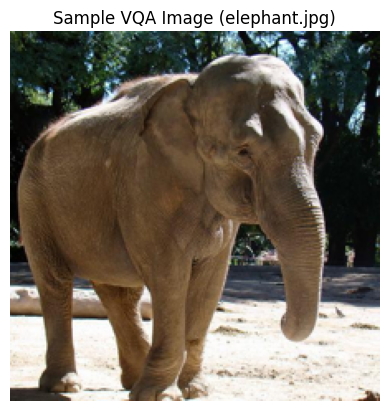

In [9]:
# Prepare Sample VQA Data

# Use the local image.jpg
sample_image_path = "elephant.jpg" 
print(f"Using local image: {sample_image_path}")

sample_questions = [
    "What type of animal is in the picture?",
    "What is the color of the animal?"
]

# Preprocess the local image
pil_image, image_tensor = preprocess_image(sample_image_path) # preprocess_image is your existing function

if pil_image:
    plt.imshow(pil_image)
    plt.title(f"Sample VQA Image ({sample_image_path})") # Updated title
    plt.axis('off')
    plt.show()
else:
    print(f"Failed to load and process the image from {sample_image_path}.")

In [10]:
# Function definition for prepare_vqa_input_corrected
# (This is the same as what you posted, which is correct for the hack strategy)

# Ensure these are available in the scope where this function is defined or called:
# import torch
# from fourm.data.modality_info import MODALITY_INFO # Assuming this is globally loaded
# from fourm.models.generate import init_full_input_modality # Assuming this is globally loaded
# device = 'cuda' if torch.cuda.is_available() else 'cpu' # Assuming this is globally defined

def prepare_vqa_input_corrected(image_tensor, question_text, text_tokenizer,
                                image_modality_key='rgb@224',
                                text_modality_key='caption',
                                answer_placeholder_len=64):
    # These globals need to be resolvable when this function is called.
    # They are typically defined in the earlier cells of your notebook.
    # global MODALITY_INFO, device, init_full_input_modality 

    if image_tensor is None or question_text is None or text_tokenizer is None:
        print("Error: image_tensor, question_text, or text_tokenizer is None.")
        return None

    num_patches_rgb = 196 
    if image_modality_key in MODALITY_INFO and isinstance(MODALITY_INFO[image_modality_key], dict):
        img_mod_dict = MODALITY_INFO[image_modality_key]
        if 'input_size' in img_mod_dict and 'patch_size' in img_mod_dict:
            input_size, patch_size = img_mod_dict['input_size'], img_mod_dict['patch_size']
            if isinstance(input_size, int) and isinstance(patch_size, int) and patch_size > 0:
                num_patches_rgb = (input_size // patch_size) ** 2
    
    batched_sample = {
        image_modality_key: {
            'tensor': image_tensor,
            'input_mask': torch.zeros(1, num_patches_rgb, dtype=torch.bool, device=device),
            'target_mask': torch.ones(1, num_patches_rgb, dtype=torch.bool, device=device),
        }
    }
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, image_modality_key, device)

    eos_id = text_tokenizer.token_to_id("[EOS]")
    s1_id = text_tokenizer.token_to_id("[S_1]") 
    s2_id = text_tokenizer.token_to_id("[S_2]") 
    pad_id = text_tokenizer.token_to_id("[PAD]")

    question_tokens = text_tokenizer.encode(question_text).ids
    
    prompt_part_ids = list(question_tokens) 
    if eos_id not in prompt_part_ids:
        prompt_part_ids.append(eos_id)
    prompt_part_ids.append(s1_id) 

    prompt_part_tensor = torch.tensor(prompt_part_ids, dtype=torch.int64, device=device).unsqueeze(0)
    prompt_part_len = prompt_part_tensor.shape[1]

    actual_answer_generate_len = max(1, answer_placeholder_len - 1) 
    answer_placeholder_ids = [pad_id] * actual_answer_generate_len
    answer_placeholder_ids.append(s2_id) 

    answer_placeholder_tensor = torch.tensor(answer_placeholder_ids, dtype=torch.int64, device=device).unsqueeze(0)
    answer_placeholder_len_actual = answer_placeholder_tensor.shape[1]

    combined_text_tensor = torch.cat([prompt_part_tensor, answer_placeholder_tensor], dim=1)
    
    combined_input_mask = torch.cat([
        torch.zeros(1, prompt_part_len, dtype=torch.bool, device=device),
        torch.ones(1, answer_placeholder_len_actual, dtype=torch.bool, device=device)
    ], dim=1)

    combined_target_mask = torch.cat([
        torch.ones(1, prompt_part_len, dtype=torch.bool, device=device),
        torch.zeros(1, answer_placeholder_len_actual, dtype=torch.bool, device=device)
    ], dim=1)
    
    combined_decoder_attention_mask = torch.zeros_like(combined_text_tensor, dtype=torch.bool, device=device)

    batched_sample[text_modality_key] = {
        'tensor': combined_text_tensor,
        'input_mask': combined_input_mask,
        'target_mask': combined_target_mask,
        'decoder_attention_mask': combined_decoder_attention_mask
    }
    
    print(f"DEBUG (prepare_vqa_input_corrected): Prompt part for merge_span_masking (input_mask=False): {prompt_part_ids}")
    print(f"DEBUG (prepare_vqa_input_corrected): Answer placeholder for AR loop (input_mask=True): {answer_placeholder_ids}")
    print(f"DEBUG (prepare_vqa_input_corrected): Combined tensor for '{text_modality_key}' shape: {batched_sample[text_modality_key]['tensor'].shape}")
    # ... other debug prints from your version are good ...

    return batched_sample

In [11]:
# notebooks/vqav2_4M-XL-21.ipynb

# Function definition for perform_vqa_inference_variant_diag (HACK V2)
# (This is the version that uses the global variable from the patch)
def perform_vqa_inference_variant_diag(
    sampler,
    batched_sample,
    text_tokenizer,
    original_question_eos_len,      # Length of "Question + EOS"
    cond_domains=['rgb@224', 'caption'],
    target_domain='caption',
    tokens_per_target=64,           # Should match answer_placeholder_len
    decoding_steps=1,
    temp=0.7,
    top_p=0.9,
    top_k=0,
    min_forced_decode_len=0  # New parameter added
):
    global LAST_DECODER_SEQ_FROM_PATCH_V2 
    pad_id = text_tokenizer.token_to_id("[PAD]") 

    if sampler is None or batched_sample is None or text_tokenizer is None:
        print("DEBUG (Variant): Error - Model, input, or tokenizer not available.")
        return "Model or input not available."

    # Ensure build_chained_generation_schedules is available
    schedule = build_chained_generation_schedules(
        cond_domains=cond_domains, target_domains=[target_domain],
        tokens_per_target=[tokens_per_target], autoregression_schemes=['autoregressive'],
        decoding_steps=[decoding_steps], token_decoding_schedules=['linear'],
        temps=[temp], temp_schedules=['constant'], cfg_scales=[1.0],
        cfg_schedules=['constant'], cfg_grow_conditioning=True,
    )

    try:
        LAST_DECODER_SEQ_FROM_PATCH_V2 = None # Reset global before the call

        print(f"DEBUG (Variant): Input to sampler for '{target_domain}':")
        if target_domain in batched_sample and isinstance(batched_sample[target_domain], dict):
            tensor_val = batched_sample[target_domain].get('tensor')
            input_mask_val = batched_sample[target_domain].get('input_mask')
            target_mask_val = batched_sample[target_domain].get('target_mask')
            print(f"  tensor shape: {tensor_val.shape if tensor_val is not None else 'None'}")
            # print(f"  tensor: {tensor_val}") # Can be very verbose
            print(f"  input_mask shape: {input_mask_val.shape if input_mask_val is not None else 'None'}")
            print(f"  target_mask shape: {target_mask_val.shape if target_mask_val is not None else 'None'}")
        
        out_dict = sampler.generate( 
            batched_sample, schedule, text_tokenizer=text_tokenizer, 
            verbose=True, seed=None, top_p=top_p, top_k=top_k,
            min_forced_decode_len=min_forced_decode_len # Pass new parameter here
        )

        actual_answer_tokens = []
        # This part now prioritizes the globally stored decoder_seq
        if LAST_DECODER_SEQ_FROM_PATCH_V2 is not None:
            print(f"DEBUG (Variant) HACK_V2: Using globally stored decoder_seq (len: {len(LAST_DECODER_SEQ_FROM_PATCH_V2)})")
            actual_answer_tokens = list(LAST_DECODER_SEQ_FROM_PATCH_V2) 
            
            if len(actual_answer_tokens) > 0 and actual_answer_tokens[0] == pad_id:
                print(f"DEBUG (Variant) HACK_V2: First token of captured decoder_seq is PAD_ID ({actual_answer_tokens[0]}). Relying on skip_special_tokens.")
                # Consider if stripping actual_answer_tokens = actual_answer_tokens[1:] is needed
                # if the PAD is never a meaningful start to the answer.
                # For now, let skip_special_tokens handle it.
        else:
            print(f"DEBUG (Variant) HACK_V2: Global decoder_seq is None. Using (likely truncated) sampler.generate output.")
            # Fallback to original (likely failing) method if patch didn't populate global
            raw_output_tensor_from_sampler = out_dict.get(target_domain, {}).get('tensor')
            if raw_output_tensor_from_sampler is None or raw_output_tensor_from_sampler.nelement() == 0:
                print("DEBUG (Variant) Fallback: Sampler returned empty or no tensor for target_domain.")
                return "Error: Sampler returned no tensor."
            
            print(f"DEBUG (Variant): ABSOLUTE RAW TENSOR FROM SAMPLER (fallback): {raw_output_tensor_from_sampler}")
            print(f"DEBUG (Variant): ABSOLUTE RAW TENSOR SHAPE (fallback): {raw_output_tensor_from_sampler.shape}")
            
            raw_output_tokens = raw_output_tensor_from_sampler[0].tolist()
            if len(raw_output_tokens) > original_question_eos_len:
                 actual_answer_tokens = raw_output_tokens[original_question_eos_len:]
            else:
                 actual_answer_tokens = [] # Will lead to empty answer
        
        print(f"DEBUG (Variant): Tokens for S2/EOS processing (actual_answer_tokens): {actual_answer_tokens}")
        
        s2_id = text_tokenizer.token_to_id("[S_2]")
        eos_id = text_tokenizer.token_to_id("[EOS]") 
        final_tokens_for_decoding = list(actual_answer_tokens)

        s2_idx_in_answer = -1; eos_idx_in_answer = -1
        try:
            if s2_id in final_tokens_for_decoding: s2_idx_in_answer = final_tokens_for_decoding.index(s2_id)
        except ValueError: pass # s2_id not found
        try:
            if eos_id in final_tokens_for_decoding: eos_idx_in_answer = final_tokens_for_decoding.index(eos_id)
        except ValueError: pass # eos_id not found


        trunc_idx = -1
        if s2_idx_in_answer != -1 and eos_idx_in_answer != -1: trunc_idx = min(s2_idx_in_answer, eos_idx_in_answer)
        elif s2_idx_in_answer != -1: trunc_idx = s2_idx_in_answer
        elif eos_idx_in_answer != -1: trunc_idx = eos_idx_in_answer
        
        if trunc_idx != -1:
            final_tokens_for_decoding = final_tokens_for_decoding[:trunc_idx]
        
        print(f"DEBUG (Variant): Final tokens for decoding (after S2/EOS strip): {final_tokens_for_decoding}")

        if not final_tokens_for_decoding:
            print(f"DEBUG (Variant): No tokens left after S2/EOS stripping or answer was initially empty.")
            return ""

        decoded_answer = text_tokenizer.decode(final_tokens_for_decoding, skip_special_tokens=True)
        print(f"DEBUG (Variant): Final decoded answer (skip_special_tokens=True): '{decoded_answer}'")
        
        return decoded_answer.strip()

    except Exception as e:
        print(f"Error during VQA inference execution: {e}")
        # Ensure traceback is imported if not already
        import traceback 
        traceback.print_exc()
        return "Error in VQA generation execution."


# Perform VQA with Base Model

In [12]:
print("--- VQA with Base 4M-21_XL Model ---")
base_model_answers = {}

print("Loading base 4M-21_XL model to GPU...")
fm_base = None
sampler_base = None
try:
    fm_base = FM.from_pretrained('EPFL-VILAB/4M-21_XL').eval().to(device)
    sampler_base = GenerationSampler(fm_base)
    print("Base model loaded successfully to GPU.")

    if image_tensor is not None and text_tok is not None:
        for i, q_text in enumerate(sample_questions):
            print(f"\nQuestion {i+1}: {q_text}")

            # Calculate original_question_eos_len for the current question
            q_tokens_for_len = text_tok.encode(q_text).ids
            eos_id_for_len = text_tok.token_to_id("[EOS]")
            if eos_id_for_len not in q_tokens_for_len:
                q_tokens_for_len.append(eos_id_for_len)
            current_original_question_eos_len = len(q_tokens_for_len)

            # Define the length for the answer placeholder part
            # This should match `tokens_per_target` in the inference call
            answer_placeholder_length = 64 # Or your desired VQA answer length capacity

            batched_input = prepare_vqa_input_corrected(
                image_tensor,
                q_text,
                text_tok,
                answer_placeholder_len=answer_placeholder_length
            )

            if batched_input:
                answer = perform_vqa_inference_variant_diag(
                    sampler_base,
                    batched_input,
                    text_tok,
                    original_question_eos_len=current_original_question_eos_len, # Pass the calculated length
                    tokens_per_target=answer_placeholder_length, # Match placeholder length
                    temp=0.7, # Your desired sampling params
                    top_p=0.9
                )
                print(f"Base Model Answer: {answer}")
                base_model_answers[q_text] = answer
            else:
                print("Failed to prepare VQA input for base model.")
                base_model_answers[q_text] = "Error in input preparation."
    else:
        print("Image or tokenizer not available. Skipping VQA with base model.")
        base_model_answers = {q: "N/A" for q in sample_questions}

except Exception as e:
    print(f"Error during base model VQA: {e}")
    import traceback
    traceback.print_exc()
    base_model_answers = {q: f"Error: {e}" for q in sample_questions}
finally:
    if sampler_base: del sampler_base
    if fm_base: del fm_base
    if 'gc' in globals(): gc.collect()
    if device == 'cuda': torch.cuda.empty_cache()
    print("Base model and sampler removed from memory.")


--- VQA with Base 4M-21_XL Model ---
Loading base 4M-21_XL model to GPU...
Base model loaded successfully to GPU.

Question 1: What type of animal is in the picture?
DEBUG (prepare_vqa_input_corrected): Prompt part for merge_span_masking (input_mask=False): [6009, 6515, 4925, 5186, 4966, 4921, 4912, 5775, 4313, 3, 5]
DEBUG (prepare_vqa_input_corrected): Answer placeholder for AR loop (input_mask=True): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6]
DEBUG (prepare_vqa_input_corrected): Combined tensor for 'caption' shape: torch.Size([1, 75])
DEBUG (Variant): Input to sampler for 'caption':
  tensor shape: torch.Size([1, 75])
  input_mask shape: torch.Size([1, 75])
  target_mask shape: torch.Size([1, 75])


1it [00:03,  3.01s/it]


DEBUG HACK_V2 Patch: CUSTOM CALLED!
DEBUG HACK_V2 Patch:   input_seq (len 11): [6009, 6515, 4925, 5186, 4966, 4921, 4912, 5775, 4313, 3, 5]
DEBUG HACK_V2 Patch:   decoder_seq (len 6): [0, 7909, 4966, 4998, 3, 6]
DEBUG HACK_V2 Patch:   VQA case DETECTED.
DEBUG HACK_V2 Patch:   Stored decoder_seq globally (len: 6).
DEBUG (Variant) HACK_V2: Using globally stored decoder_seq (len: 6)
DEBUG (Variant) HACK_V2: First token of captured decoder_seq is PAD_ID (0). Relying on skip_special_tokens.
DEBUG (Variant): Tokens for S2/EOS processing (actual_answer_tokens): [0, 7909, 4966, 4998, 3, 6]
DEBUG (Variant): Final tokens for decoding (after S2/EOS strip): [0, 7909, 4966, 4998]
DEBUG (Variant): Final decoded answer (skip_special_tokens=True): 'why is that'
Base Model Answer: why is that

Question 2: What is the color of the animal?
DEBUG (prepare_vqa_input_corrected): Prompt part for merge_span_masking (input_mask=False): [6009, 4966, 4912, 5206, 4925, 4912, 5186, 4313, 3, 5]
DEBUG (prepare_vqa_i

1it [00:00,  4.92it/s]

DEBUG HACK_V2 Patch: CUSTOM CALLED!
DEBUG HACK_V2 Patch:   input_seq (len 10): [6009, 4966, 4912, 5206, 4925, 4912, 5186, 4313, 3, 5]
DEBUG HACK_V2 Patch:   decoder_seq (len 7): [0, 4912, 6783, 4234, 4313, 3, 6]
DEBUG HACK_V2 Patch:   VQA case DETECTED.
DEBUG HACK_V2 Patch:   Stored decoder_seq globally (len: 7).
DEBUG (Variant) HACK_V2: Using globally stored decoder_seq (len: 7)
DEBUG (Variant) HACK_V2: First token of captured decoder_seq is PAD_ID (0). Relying on skip_special_tokens.
DEBUG (Variant): Tokens for S2/EOS processing (actual_answer_tokens): [0, 4912, 6783, 4234, 4313, 3, 6]
DEBUG (Variant): Final tokens for decoding (after S2/EOS strip): [0, 4912, 6783, 4234, 4313]
DEBUG (Variant): Final decoded answer (skip_special_tokens=True): 'the asian?'
Base Model Answer: the asian?


Base model and sampler removed from memory.


# Perform VQA with Fine-tuned Model

In [13]:
print("\n--- VQA with Fine-tuned 4M-21_XL Model ---")
finetuned_model_answers = {}

finetuned_weights_path = os.path.join('./checkpoints/checkpoint-4.safetensors')


print(f"Fine-tuned weights path: {finetuned_weights_path}")

print("Loading fine-tuned 4M-21_XL model to GPU...")
fm_finetuned = None
sampler_finetuned = None

try:
    fm_finetuned = FM.from_pretrained('EPFL-VILAB/4M-21_XL').eval()
    print("Base architecture for fine-tuned model loaded to CPU.")

    if os.path.exists(finetuned_weights_path): # Make sure os is imported
        # from safetensors.torch import load_file as load_safetensors # Ensure loaded
        state_dict = load_safetensors(finetuned_weights_path, device='cpu')
        
        has_module_prefix = any(key.startswith('module.') for key in state_dict.keys())
        state_dict_to_load = {}
        if has_module_prefix:
            print("Found 'module.' prefix in checkpoint keys. Stripping prefix...")
            for k, v in state_dict.items():
                name = k[7:] if k.startswith('module.') else k
                state_dict_to_load[name] = v
        else:
            state_dict_to_load = state_dict

        missing_keys, unexpected_keys = fm_finetuned.load_state_dict(state_dict_to_load, strict=False)
        print(f"Fine-tuned weights loaded. Missing: {len(missing_keys)}, Unexpected: {len(unexpected_keys)}")
        if missing_keys: print(f"Missing examples: {missing_keys[:5]}")
        if unexpected_keys: print(f"Unexpected examples: {unexpected_keys[:5]}")

        print("Moving fine-tuned model to GPU...")
        fm_finetuned = fm_finetuned.to(device)
        print("Fine-tuned model moved to GPU.")
        sampler_finetuned = GenerationSampler(fm_finetuned)
        print("Fine-tuned model and sampler ready on GPU.")

        if image_tensor is not None and text_tok is not None:
            for i, q_text in enumerate(sample_questions):
                print(f"\nQuestion {i+1}: {q_text}")

                # Calculate original_question_eos_len for the current question
                q_tokens_for_len = text_tok.encode(q_text).ids
                eos_id_for_len = text_tok.token_to_id("[EOS]")
                if eos_id_for_len not in q_tokens_for_len:
                    q_tokens_for_len.append(eos_id_for_len)
                current_original_question_eos_len = len(q_tokens_for_len)

                answer_placeholder_length = 64 # Or your desired VQA answer length capacity

                batched_input = prepare_vqa_input_corrected(
                    image_tensor,
                    q_text,
                    text_tok,
                    answer_placeholder_len=answer_placeholder_length
                )
                
                if batched_input:
                    answer = perform_vqa_inference_variant_diag(
                        sampler_finetuned,
                        batched_input,
                        text_tok,
                        original_question_eos_len=current_original_question_eos_len,
                        tokens_per_target=answer_placeholder_length,
                        temp=0.7,
                        top_p=0.95, 
                        min_forced_decode_len=1
                    )
                    print(f"Fine-tuned Model Answer: {answer}")
                    finetuned_model_answers[q_text] = answer
                else:
                    print("Failed to prepare VQA input for fine-tuned model.")
                    finetuned_model_answers[q_text] = "Error in input preparation."
        else:
            print("Image or tokenizer not available. Skipping VQA with fine-tuned model.")
            finetuned_model_answers = {q: "N/A" for q in sample_questions}
            
    else:
        print(f"ERROR: Fine-tuned weights file not found at {finetuned_weights_path}")
        finetuned_model_answers = {q: "Weights not found" for q in sample_questions}

except Exception as e:
    print(f"An error occurred while loading/using the fine-tuned model: {e}")
    import traceback
    traceback.print_exc()
    finetuned_model_answers = {q: f"Error: {e}" for q in sample_questions}
finally:
    if sampler_finetuned: del sampler_finetuned
    if fm_finetuned: del fm_finetuned
    if 'gc' in globals(): gc.collect()
    if device == 'cuda': torch.cuda.empty_cache()
    print("Fine-tuned model and sampler removed from memory.")



--- VQA with Fine-tuned 4M-21_XL Model ---
Fine-tuned weights path: ./checkpoints/checkpoint-4.safetensors
Loading fine-tuned 4M-21_XL model to GPU...
Base architecture for fine-tuned model loaded to CPU.
Fine-tuned weights loaded. Missing: 116, Unexpected: 0
Missing examples: ['encoder_embeddings.t5_caption.mod_emb', 'encoder_embeddings.t5_caption.pos_emb', 'encoder_embeddings.t5_caption.emb_proj.weight', 'encoder_embeddings.t5_caption.emb_proj.bias', 'encoder_embeddings.det.mod_emb']
Moving fine-tuned model to GPU...
Fine-tuned model moved to GPU.
Fine-tuned model and sampler ready on GPU.

Question 1: What type of animal is in the picture?
DEBUG (prepare_vqa_input_corrected): Prompt part for merge_span_masking (input_mask=False): [6009, 6515, 4925, 5186, 4966, 4921, 4912, 5775, 4313, 3, 5]
DEBUG (prepare_vqa_input_corrected): Answer placeholder for AR loop (input_mask=True): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

 ... (more hidden) ...


DEBUG HACK_V2 Patch: CUSTOM CALLED!
DEBUG HACK_V2 Patch:   input_seq (len 11): [6009, 6515, 4925, 5186, 4966, 4921, 4912, 5775, 4313, 3, 5]
DEBUG HACK_V2 Patch:   decoder_seq (len 5): [0, 5109, 5186, 4313, 6]
DEBUG HACK_V2 Patch:   VQA case DETECTED.
DEBUG HACK_V2 Patch:   Stored decoder_seq globally (len: 5).
DEBUG (Variant) HACK_V2: Using globally stored decoder_seq (len: 5)
DEBUG (Variant) HACK_V2: First token of captured decoder_seq is PAD_ID (0). Relying on skip_special_tokens.
DEBUG (Variant): Tokens for S2/EOS processing (actual_answer_tokens): [0, 5109, 5186, 4313, 6]
DEBUG (Variant): Final tokens for decoding (after S2/EOS strip): [0, 5109, 5186, 4313]
DEBUG (Variant): Final decoded answer (skip_special_tokens=True): 'this animal?'
Fine-tuned Model Answer: this animal?

Question 2: What is the color of the animal?
DEBUG (prepare_vqa_input_corrected): Prompt part for merge_span_masking (input_mask=False): [6009, 4966, 4912, 5206, 4925, 4912, 5186, 4313, 3, 5]
DEBUG (prepare_vqa

 ... (more hidden) ...

DEBUG HACK_V2 Patch: CUSTOM CALLED!
DEBUG HACK_V2 Patch:   input_seq (len 10): [6009, 4966, 4912, 5206, 4925, 4912, 5186, 4313, 3, 5]
DEBUG HACK_V2 Patch:   decoder_seq (len 24): [0, 6009, 4966, 5020, 4234, 4313, 5141, 4953, 7369, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4953, 4313, 4295, 4313, 3, 6]
DEBUG HACK_V2 Patch:   VQA case DETECTED.
DEBUG HACK_V2 Patch:   Stored decoder_seq globally (len: 24).
DEBUG (Variant) HACK_V2: Using globally stored decoder_seq (len: 24)
DEBUG (Variant) HACK_V2: First token of captured decoder_seq is PAD_ID (0). Relying on skip_special_tokens.
DEBUG (Variant): Tokens for S2/EOS processing (actual_answer_tokens): [0, 6009, 4966, 5020, 4234, 4313, 5141, 4953, 7369, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4953, 4313, 4295, 4313, 3, 6]
DEBUG (Variant): Final tokens for decoding (after S2/EOS strip): [0, 6009, 4966, 5020, 4234, 4313, 5141, 4953, 7369, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4313, 4953, 4313, 4295, 4313]
DEB

Fine-tuned model and sampler removed from memory.


# Comparison and Visualization

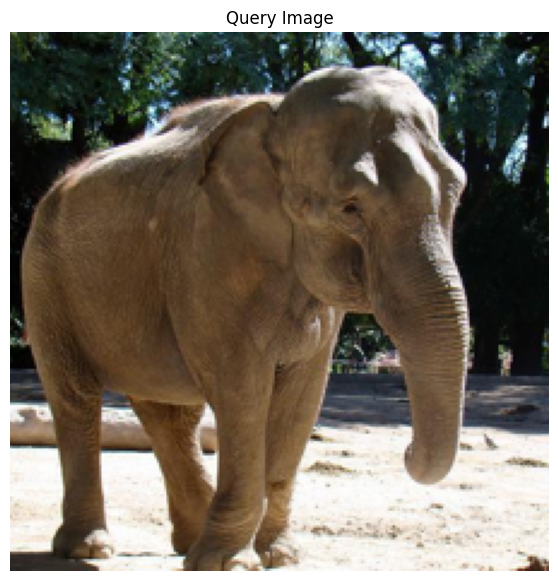


--- Comparison Summary ---

Question: What type of animal is in the picture?
  Base Model Answer: why is that
  Fine-tuned Model Answer: this animal?

Question: What is the color of the animal?
  Base Model Answer: the asian?
  Fine-tuned Model Answer: what is white? look to cutting????????? to? -?


In [14]:
# Cell E: Comparison and Visualization (Your existing Cell 9)
# This cell should now work as expected using the populated dictionaries.
# ... (your existing code for plotting/printing comparisons) ...

if pil_image: # Make sure pil_image is still available from Cell "B"
    num_questions = len(sample_questions)
    
    fig_img, ax_img = plt.subplots(1,1, figsize=(7,7))
    ax_img.imshow(pil_image)
    ax_img.set_title("Query Image")
    ax_img.axis('off')
    plt.show()

    print("\n--- Comparison Summary ---")
    for q_text in sample_questions:
        print(f"\nQuestion: {q_text}")
        print(f"  Base Model Answer: {base_model_answers.get(q_text, 'N/A')}")
        print(f"  Fine-tuned Model Answer: {finetuned_model_answers.get(q_text, 'N/A')}")
else:
    print("Cannot display comparison as image was not loaded.")